In [ ]:
library(BUSpaRse)
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(DoubletFinder)
library(future)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 4,]$genes)

# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

setwd(here())

In [1]:
# THIS IS THE PREPROCESSING TO GET TO THE INTEGRATED SEURAT OBJECT. JUST UNCOMMENT ENTIRE CELL.

YFP_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_101.rds")
YFP_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_103.rds")
KE_1_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_102.rds")
KE_2_seu = readRDS(file = "../data/seurat_objects/seurat_raw_3_11_21/sc_104.rds")

In [2]:
dim(YFP_1_seu@meta.data)
dim(YFP_2_seu@meta.data)
dim(KE_1_seu@meta.data)
dim(KE_2_seu@meta.data)

[1] 878  11

[1] 211  11

[1] 1302   11

[1] 1125   11

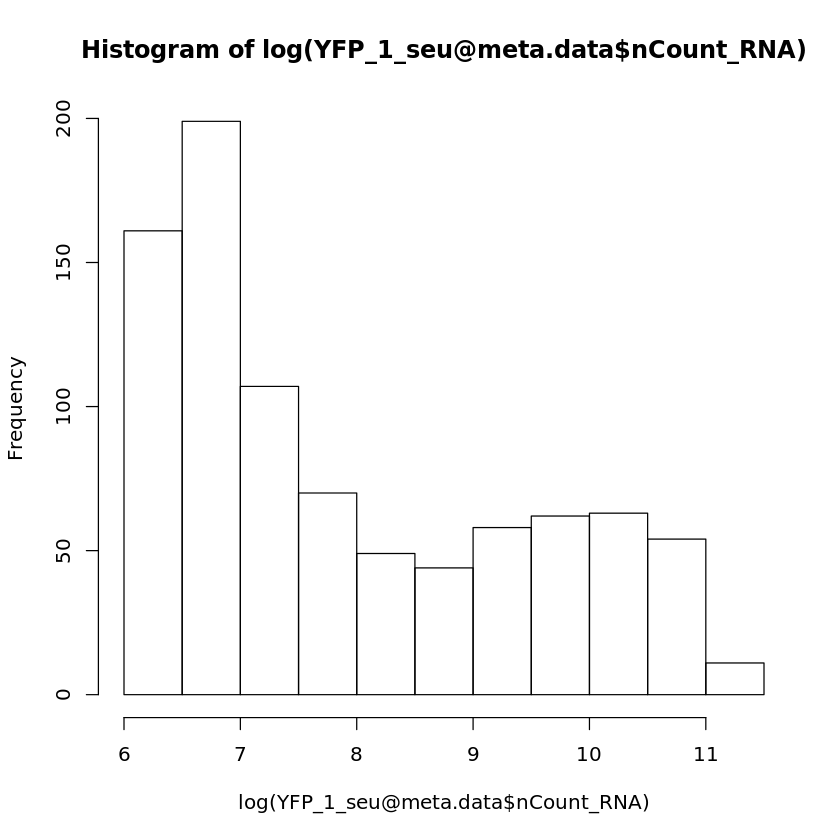

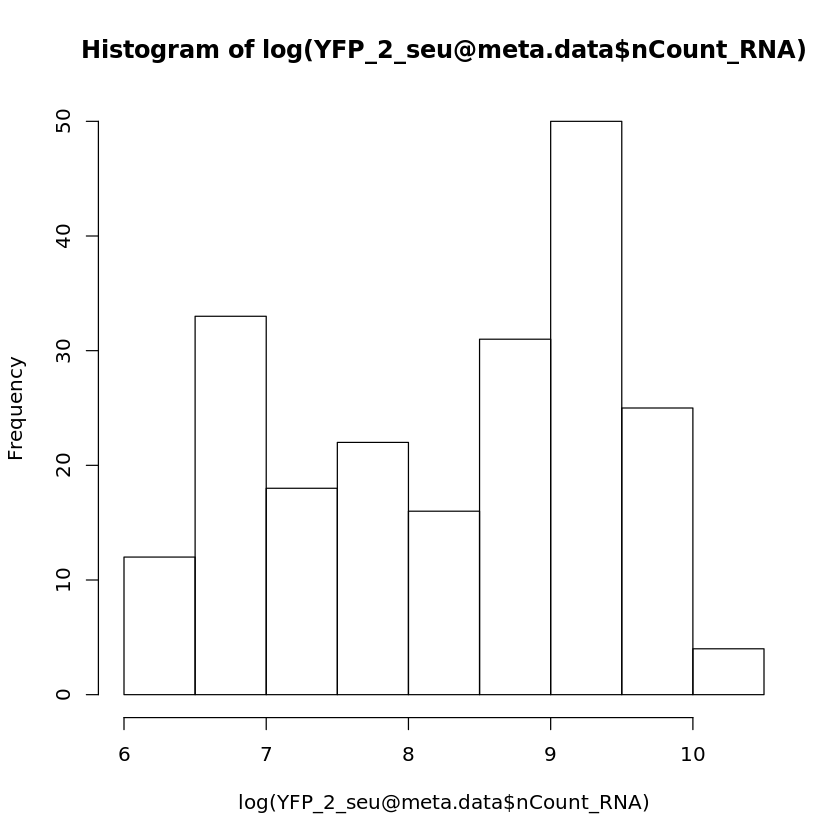

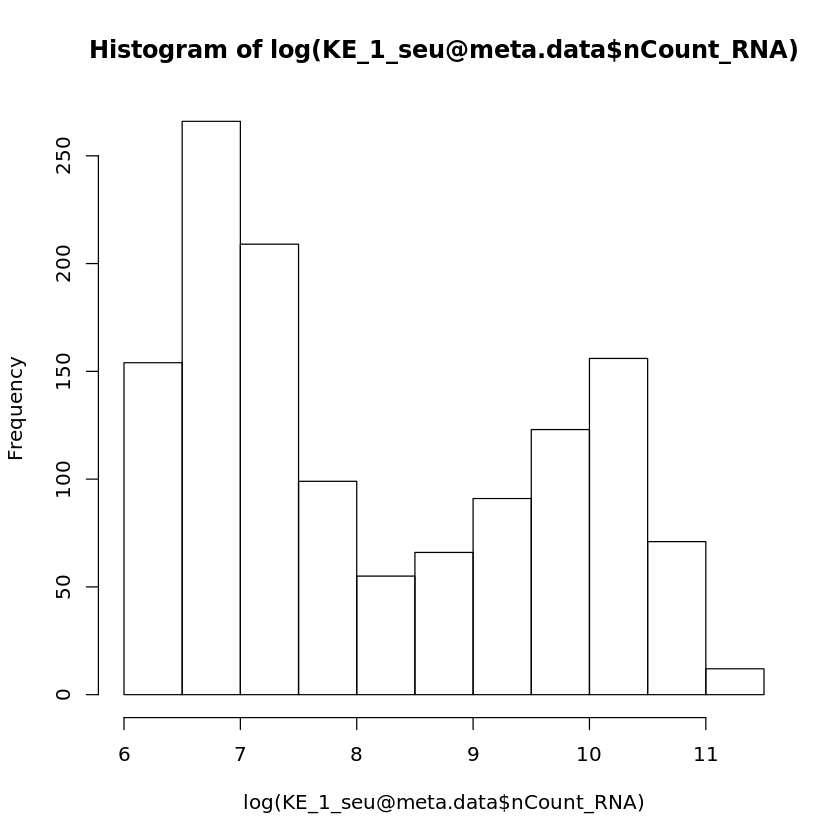

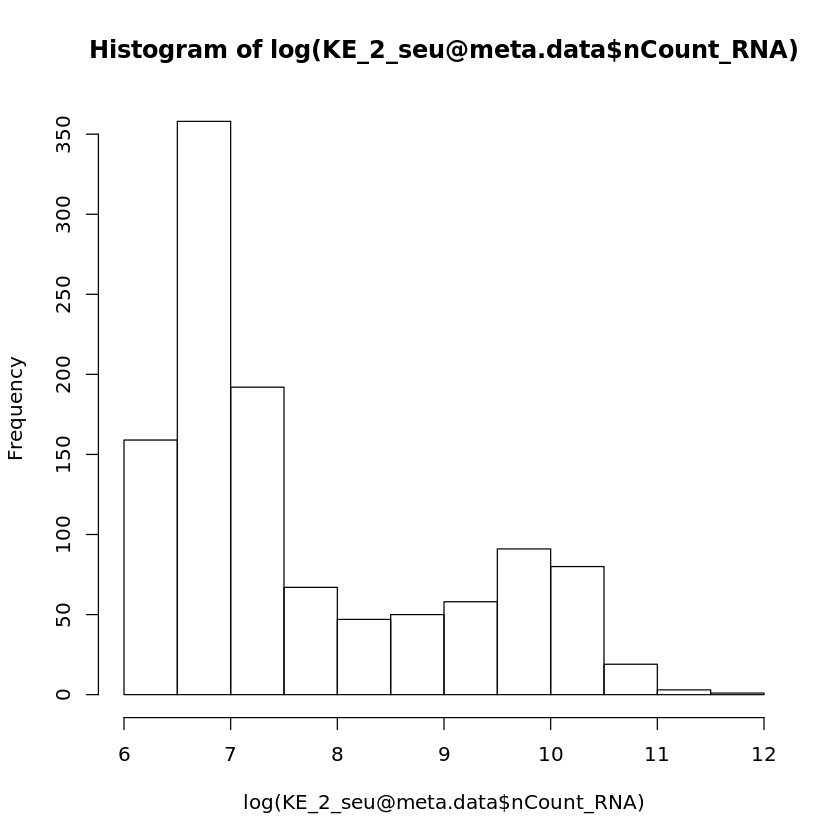

In [3]:
hist(log(YFP_1_seu@meta.data$nCount_RNA))
hist(log(YFP_2_seu@meta.data$nCount_RNA))
hist(log(KE_1_seu@meta.data$nCount_RNA))
hist(log(KE_2_seu@meta.data$nCount_RNA))

In [4]:
thr_low = 500
thr_high_percentile = .99

thr_high =  quantile(YFP_1_seu@meta.data$nCount_RNA, .99)
YFP_1_seu <- subset(YFP_1_seu, subset = percent.mito < 10 & nCount_RNA > thr_low  & nCount_RNA < thr_high) # & YFP_1_seu@meta.data[,7] =="Singlet")
dim(YFP_1_seu@assays$RNA)

thr_high =  quantile(YFP_2_seu@meta.data$nCount_RNA, .99)
YFP_2_seu <- subset(YFP_2_seu, subset = percent.mito < 10 & nCount_RNA > thr_low  & nCount_RNA < thr_high) # &  YFP_2_seu@meta.data[,7] =="Singlet")
dim(YFP_2_seu@assays$RNA)

thr_high =  quantile(KE_1_seu@meta.data$nCount_RNA, .99)
KE_1_seu <- subset(KE_1_seu, subset = percent.mito < 10 & nCount_RNA > thr_low  & nCount_RNA < thr_high) # & KE_1_seu@meta.data[,7] =="Singlet")
dim(KE_1_seu@assays$RNA)

thr_high =  quantile(KE_2_seu@meta.data$nCount_RNA, .99)
KE_2_seu <- subset(KE_2_seu, subset = percent.mito < 10 & nCount_RNA > thr_low  & nCount_RNA < thr_high) # & KE_2_seu@meta.data[,7] =="Singlet")
dim(KE_2_seu@assays$RNA)


Loading required package: Seurat



[1] 17889   869

[1] 13317   208

[1] 18893  1288

[1] 17351  1113

In [10]:
#KE_1
genes_per_cell = (Matrix::colSums((YFP_1_seu@assays$RNA@counts)>0))
#mean(genes_per_cell)
median(genes_per_cell)
median(Matrix::colSums(YFP_1_seu@assays$RNA@counts))

#wt_2
genes_per_cell = (Matrix::colSums((YFP_2_seu@assays$RNA@counts)>0))
#mean(genes_per_cell)
median(genes_per_cell)
median(Matrix::colSums(YFP_2_seu@assays$RNA@counts))

#KE_1
genes_per_cell = KE_1_seu@meta.data$nFeature_RNA
#mean(genes_per_cell)
median(genes_per_cell)
median(KE_1_seu@meta.data$nCount_RNA)

#KE_2
genes_per_cell = (Matrix::colSums((KE_2_seu@assays$RNA@counts)>0))
#mean(genes_per_cell)
median(genes_per_cell)
median(Matrix::colSums(KE_2_seu@assays$RNA@counts))

[1] 733

[1] 1486

[1] 1818

[1] 5564.5

[1] 932

[1] 1910.5

[1] 676

[1] 1167

In [12]:

#Perform SCTransform
defaultW <- getOption("warn") 
options(warn = -1) 
YFP_1_seu = SCTransform(YFP_1_seu, verbose = FALSE, vars.to.regress = c("percent.mito", "percent.cp"))
YFP_2_seu = SCTransform(YFP_2_seu, verbose = FALSE, vars.to.regress = c("percent.mito", "percent.cp"))
KE_1_seu = SCTransform(KE_1_seu, verbose = FALSE, vars.to.regress = c("percent.mito", "percent.cp"))
KE_2_seu = SCTransform(KE_2_seu, verbose = FALSE, vars.to.regress = c("percent.mito", "percent.cp"))
options(warn = defaultW)

all_intd_sct = seu_integrate(YFP_1_seu, YFP_2_seu, KE_1_seu, KE_2_seu, filename = "sorted_YFP_3_30_21", nfeatures = 5000)

#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
all_intd_sct@meta.data$orig.ident = c(rep("YFP_1",length(colnames(YFP_1_seu@assays$RNA))), rep("YFP_2",length(colnames(YFP_2_seu@assays$RNA))), rep("KE_1",length(colnames(KE_1_seu@assays$RNA))), rep("KE_2",length(colnames(KE_2_seu@assays$RNA))))
all_intd_sct@meta.data$orig.geno = c(rep("YFP",length(colnames(YFP_1_seu@assays$RNA)) + length(colnames(YFP_2_seu@assays$RNA))), rep("KE",length(colnames(KE_1_seu@assays$RNA)) + length(colnames(KE_2_seu@assays$RNA))))

#saveRDS(all_intd_sct, "../data/intd_seu_objects/std_intd_all_SCT_mt_removed_minus_protos_mt_cp_4_5_21.rds")

21:20:57 UMAP embedding parameters a = 0.9922 b = 1.112

21:20:57 Read 3478 rows and found 50 numeric columns

21:20:57 Using Annoy for neighbor search, n_neighbors = 30

21:20:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:20:58 Writing NN index file to temp file /tmp/Rtmp4qWGOn/file227d21e57e86

21:20:58 Searching Annoy index using 1 thread, search_k = 3000

21:20:59 Annoy recall = 100%

21:21:00 Commencing smooth kNN distance calibration using 1 thread

21:21:01 Initializing from normalized Laplacian + noise

21:21:02 Commencing optimization for 500 epochs, with 145008 positive edges

21:21:16 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3478
Number of edges: 113153

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8165
Number of communities: 14
Elapsed time: 0 seconds


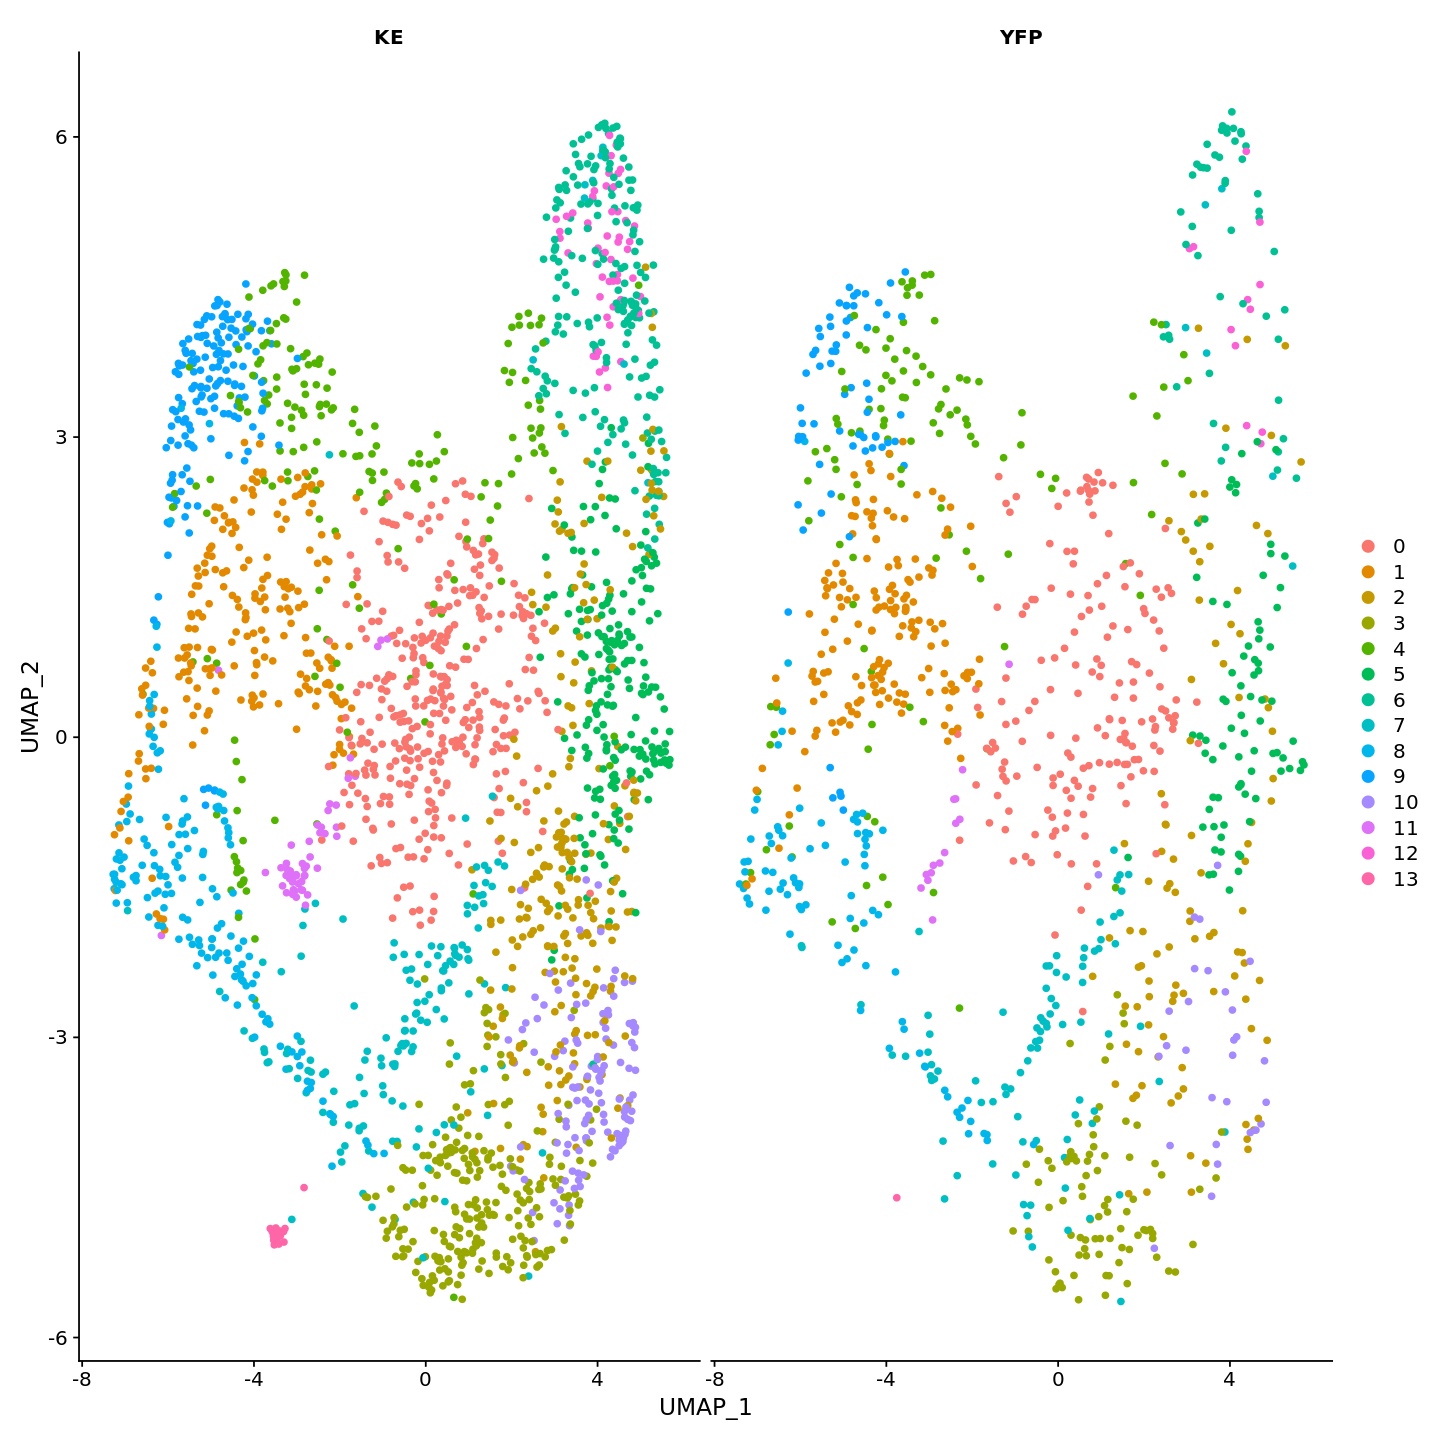

In [19]:
DefaultAssay(all_intd_sct) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
all_intd_sct <- RunPCA(all_intd_sct, npcs = 50, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.
all_intd_sct <- RunUMAP(all_intd_sct, reduction = "pca", dims = 1:50)
all_intd_sct <- FindNeighbors(all_intd_sct, dims = 1:50)
all_intd_sct <- FindClusters(all_intd_sct, resolution = 0.7)
DimPlot(all_intd_sct, reduction = "umap", label = FALSE, pt.size = 1.5, split.by = "orig.geno")

In [31]:
sum(subset(all_intd_sct, subset = orig.geno =="YFP")@assays$RNA["AT2G40205",])/1100
sum(subset(all_intd_sct, subset = orig.geno =="KE")@assays$RNA["AT2G40205",])/2400

[1] 5.400909

[1] 2.7125

Warning message in CheckDuplicateCellNames(object.list = object.list):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Finding neighborhoods

Finding anchors

	Found 556 anchors

Extracting within-dataset neighbors

Calculating residuals of type pearson for 7848 genes



  |======================================================================| 100%


Calculating residuals of type pearson for 7848 genes



  |======================================================================| 100%


Integrating dataset 2 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"
21:08:42 UMAP embedding parameters a = 0.9922 b = 1.112

21:08:42 Read 1077 rows and found 50 numeric columns

21:08:42 Using Annoy for neighbor search, n_neighbors = 30

21:08:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

21:08:43 Writing NN index file to temp file /tmp/Rtmp4qWGOn/file227d5e7521eb

21:08:43 Searching Annoy index using 1 thread, search_k = 3000

21:08:43 Annoy recall = 100%

21:08:44 Commencing smooth kNN distance calibration using 1 thread

21:08:45 Initializing from normalized Laplacian + noise

21:08:45 Commencing optimization for 500 epochs,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1077
Number of edges: 34697

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7564
Number of communities: 8
Elapsed time: 0 seconds


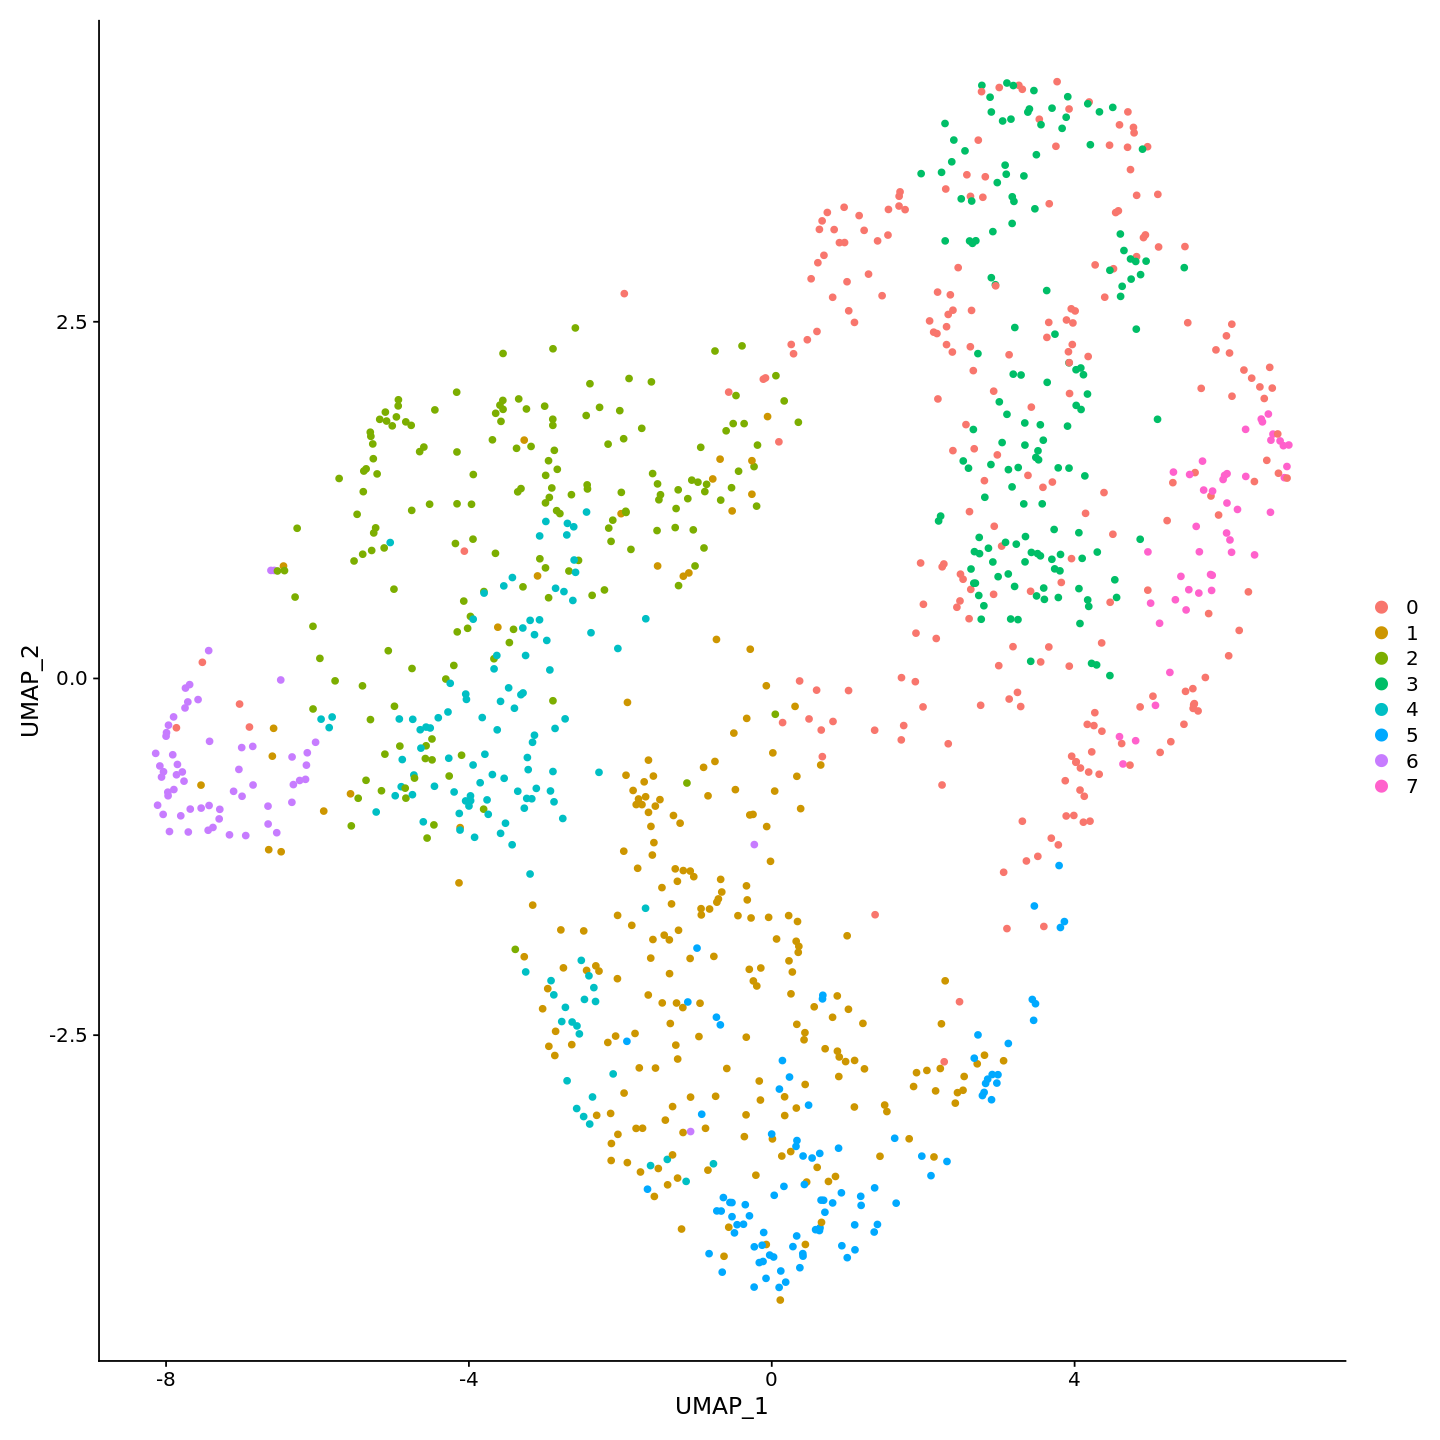

In [14]:
wt_intd_sct = seu_integrate(YFP_1_seu, YFP_2_seu, filename = "sorted_YFP_WT_4_30_21", nfeatures = 5000)

DefaultAssay(wt_intd_sct) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
wt_intd_sct <- ScaleData(wt_intd_sct, verbose = FALSE)
wt_intd_sct <- RunPCA(wt_intd_sct, npcs = 50, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.
wt_intd_sct <- RunUMAP(wt_intd_sct, reduction = "pca", dims = 1:50)
wt_intd_sct <- FindNeighbors(wt_intd_sct, dims = 1:50)
wt_intd_sct <- FindClusters(wt_intd_sct, resolution = 0.7)
DimPlot(wt_intd_sct, reduction = "umap", label = FALSE, pt.size = 1.5)

21:12:09 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2401
Number of edges: 76388

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8282
Number of communities: 14
Elapsed time: 0 seconds


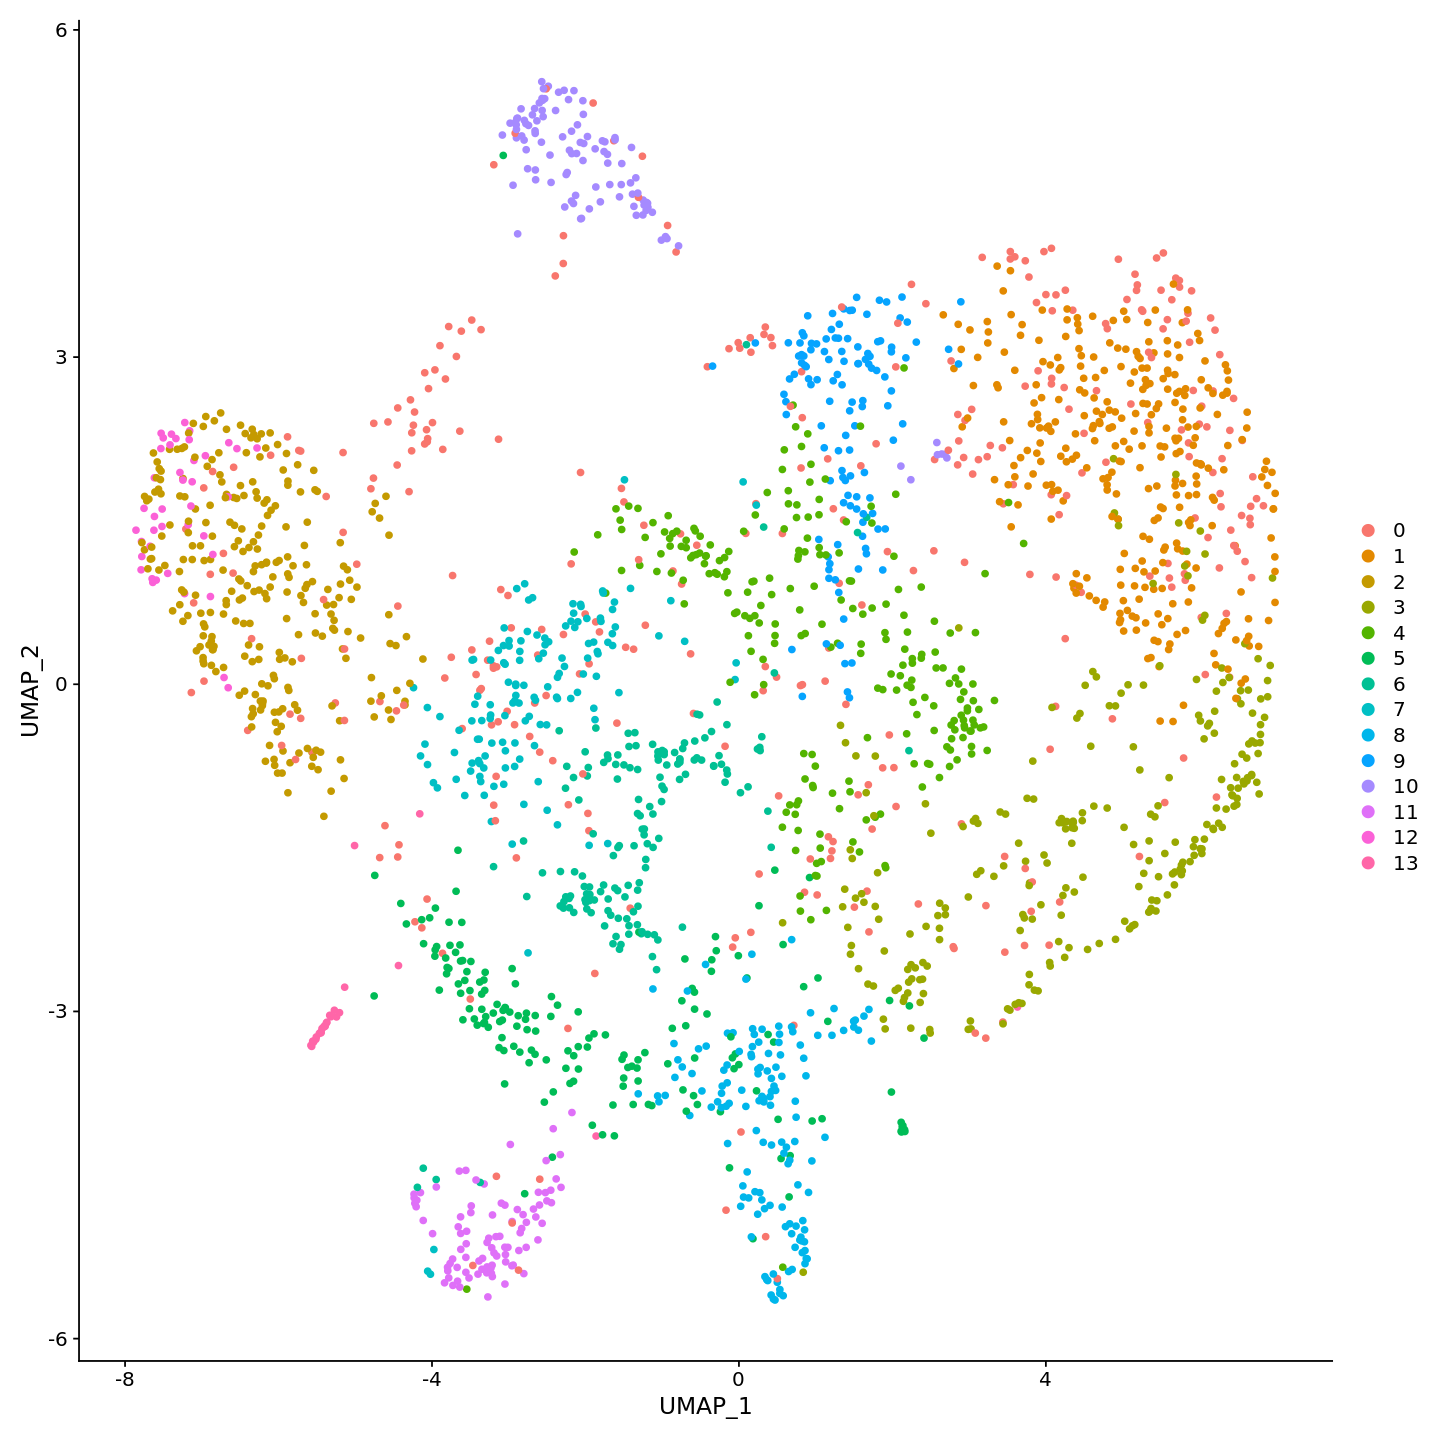

In [16]:
KE_intd_sct = seu_integrate(KE_1_seu, KE_2_seu, filename = "sorted_YFP_KE_4_30_21", nfeatures = 5000)

DefaultAssay(KE_intd_sct) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
KE_intd_sct <- ScaleData(KE_intd_sct, verbose = FALSE)
KE_intd_sct <- RunPCA(KE_intd_sct, npcs = 50, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.
KE_intd_sct <- RunUMAP(KE_intd_sct, reduction = "pca", dims = 1:50)
KE_intd_sct <- FindNeighbors(KE_intd_sct, dims = 1:50)
KE_intd_sct <- FindClusters(KE_intd_sct, resolution = 0.7)
DimPlot(KE_intd_sct, reduction = "umap", label = FALSE, pt.size = 1.5)

In [11]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))

    for (i in 1:length(seu.list)) {
        seu.list[[i]]@assays$spliced_RNA <- NULL
        seu.list[[i]]@assays$spliced_SCT <- NULL
        seu.list[[i]]@assays$unspliced_RNA <- NULL
        seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
   # rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
    }
}